In [140]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Cargo los datos y sets

In [134]:
training_labels = pd.read_csv("set_entrenamiento.csv", low_memory=False)[['person','label']]
labels_predict = pd.read_csv("trocafone_kaggle_test.csv", low_memory=False)
events_data = pd.read_csv("data_set.csv", low_memory = False)

### Comenzamos con el set de entrenamiento

In [135]:
set_entrenamiento = pd.merge(events_data, training_labels, on ='person', how = 'right')
set_entrenamiento.head()

,person,Direct,Email,Organic,Paid,Referral,Social,ad campaign hit,brand listing,checkout,...,viewed/checkouted min,viewed/checkouted max,viewed/checkout gral,Computer,Smartphone,Tablet,country_Computer,country_Smartphone,country_Tablet,label
0,001ca5ee,6.0,0.0,2.0,2.0,0.0,0.0,7,7,1,...,1.0,0.0,31.0,0.0,15.0,0.0,0.0,1.0,0.0,0
1,003476c0,0.0,0.0,1.0,2.0,0.0,0.0,6,0,0,...,0.0,0.0,-1.0,0.0,4.0,0.0,0.0,1.0,0.0,1
2,003d4cac,1.0,0.0,0.0,0.0,0.0,0.0,2,0,1,...,1.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,0.0,1
3,003dd965,0.0,0.0,0.0,1.0,0.0,0.0,0,2,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,0042421c,0.0,0.0,0.0,1.0,0.0,0.0,1,5,0,...,0.0,0.0,-1.0,2.0,0.0,0.0,1.0,0.0,0.0,1


In [136]:
train = set_entrenamiento
target = 'label'
IDcol = 'person'

In [137]:
# función que recibe el algoritmo y los datos de entramiento
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8566
AUC Score (Train): 0.940874


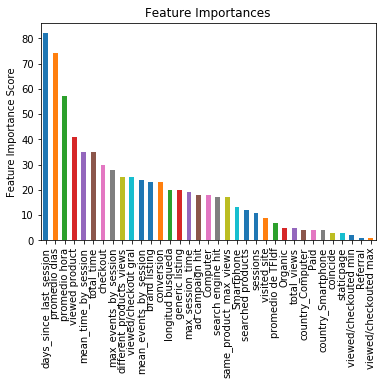

In [141]:
# predictors -> son los features (todos menos los labels y person)
predictors = [x for x in train.columns if x not in [target, IDcol]]
# le paso hiperparametros básicos primero
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
# llamo a la función
modelfit(xgb1, train, predictors)

### Tune max_depth and min_child_weight

In [142]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84628, std: 0.01993, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.84606, std: 0.02115, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.84397, std: 0.02173, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84271, std: 0.02564, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.83945, std: 0.02204, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84269, std: 0.01740, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.84245, std: 0.02120, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.84078, std: 0.02295, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83746, std: 0.01825, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83932, std: 0.01956, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83996, std: 0.02229, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.84036, std: 0.02068, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [146]:
#  mejores: {'max_depth': 3, 'min_child_weight': 1},

param_test2 = {
 'max_depth':[1,2,3,4,5,6],
 'min_child_weight':[0,0.25,0.5,0.75,1,1.25,1.5]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84050, std: 0.01528, params: {'max_depth': 1, 'min_child_weight': 0},
  mean: 0.84050, std: 0.01528, params: {'max_depth': 1, 'min_child_weight': 0.25},
  mean: 0.84050, std: 0.01528, params: {'max_depth': 1, 'min_child_weight': 0.5},
  mean: 0.84055, std: 0.01533, params: {'max_depth': 1, 'min_child_weight': 0.75},
  mean: 0.84053, std: 0.01531, params: {'max_depth': 1, 'min_child_weight': 1},
  mean: 0.84053, std: 0.01531, params: {'max_depth': 1, 'min_child_weight': 1.25},
  mean: 0.84053, std: 0.01531, params: {'max_depth': 1, 'min_child_weight': 1.5},
  mean: 0.84529, std: 0.01739, params: {'max_depth': 2, 'min_child_weight': 0},
  mean: 0.84552, std: 0.01798, params: {'max_depth': 2, 'min_child_weight': 0.25},
  mean: 0.84703, std: 0.01734, params: {'max_depth': 2, 'min_child_weight': 0.5},
  mean: 0.84713, std: 0.01760, params: {'max_depth': 2, 'min_child_weight': 0.75},
  mean: 0.84612, std: 0.01657, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.84607, st

#### los mejores fueron :
######  {'max_depth': 4, 'min_child_weight': 1}


Model Report
Accuracy : 0.8918
AUC Score (Train): 0.961740


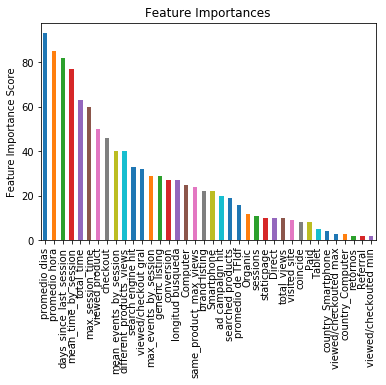

In [147]:
modelfit(gsearch2.best_estimator_, train, predictors)

## Tune gamma

In [148]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84805, std: 0.01938, params: {'gamma': 0.0},
  mean: 0.84619, std: 0.02278, params: {'gamma': 0.1},
  mean: 0.84733, std: 0.02297, params: {'gamma': 0.2},
  mean: 0.84670, std: 0.01906, params: {'gamma': 0.3},
  mean: 0.84497, std: 0.02373, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8480528946272387)

El valor original de gamma (0) es el optimo


Model Report
Accuracy : 0.8918
AUC Score (Train): 0.961740


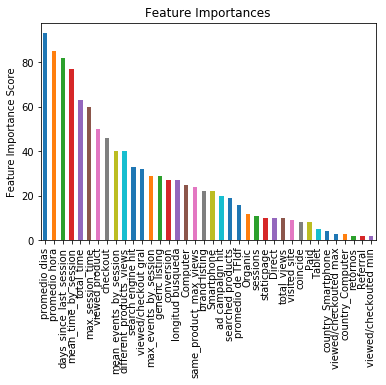

In [149]:
## con los nuevos parametros
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [150]:
#max_depth: 4
#min_child_weight: 1
#gamma: 0

## Tune subsample and colsample_bytree

In [157]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_



([mean: 0.83787, std: 0.01905, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.84329, std: 0.01612, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.84497, std: 0.01969, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.84500, std: 0.02229, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.83886, std: 0.02155, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.84033, std: 0.01905, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.84332, std: 0.01794, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.84404, std: 0.02040, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.83714, std: 0.02105, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.83962, std: 0.02204, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.84805, std: 0.01938, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.84194, std: 0.02219, params: {'colsample_bytree': 0.8, 'subsample'

In [152]:
##  {'colsample_bytree': 0.8, 'subsample': 0.8},
## igual que los default

In [158]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84295, std: 0.01913, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.84531, std: 0.02142, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.84425, std: 0.02000, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.84500, std: 0.01991, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.84805, std: 0.01938, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.84432, std: 0.02009, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.84183, std: 0.02113, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.84684, std: 0.02255, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.84115, std: 0.02166, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.8480528946272387)

In [155]:
# siguen igual: {'colsample_bytree': 0.8, 'subsample': 0.8}: son los optimos

## Tuning Regularization Parameters

In [160]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.84805, std: 0.01938, params: {'reg_alpha': 1e-05},
  mean: 0.84838, std: 0.02299, params: {'reg_alpha': 0.01},
  mean: 0.84711, std: 0.02203, params: {'reg_alpha': 0.1},
  mean: 0.84447, std: 0.02314, params: {'reg_alpha': 1},
  mean: 0.82391, std: 0.01274, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.8483756768013327)

In [161]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.84805, std: 0.01938, params: {'reg_alpha': 0},
  mean: 0.84886, std: 0.02030, params: {'reg_alpha': 0.001},
  mean: 0.84757, std: 0.02296, params: {'reg_alpha': 0.005},
  mean: 0.84838, std: 0.02299, params: {'reg_alpha': 0.01},
  mean: 0.84498, std: 0.02210, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.001},
 0.848859850062474)

In [ ]:
##  {'reg_alpha': 0.001},



Model Report
Accuracy : 0.8918
AUC Score (Train): 0.961732


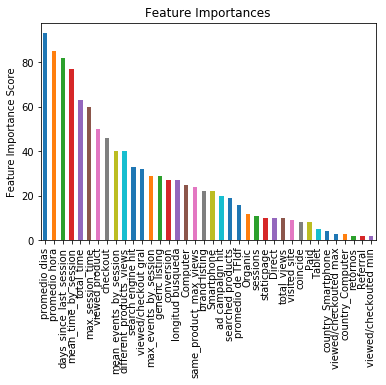

In [166]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

## Reducing Learning Rate


Model Report
Accuracy : 0.8413
AUC Score (Train): 0.925815


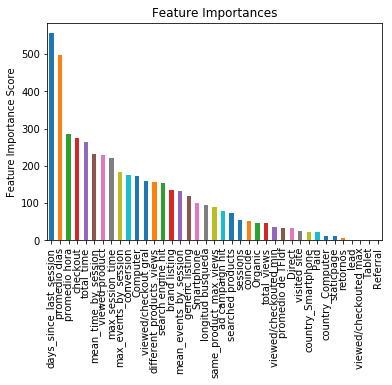

In [168]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [169]:
set_test = pd.merge(events_data,labels_predict,on = "person", how = "right")
personas = set_test["person"]
set_test = set_test.drop(columns=['person'])
set_test = set_test.fillna(0)
predicts_kaggel = xgb4.predict(set_test)

In [170]:
predicts_kaggel = predicts_kaggel.tolist()
df_kaggel = pd.DataFrame(predicts_kaggel)
df_kaggel.head()

,0
0,0
1,1
2,1
3,1
4,0


In [171]:
media = df_kaggel[0].mean()
std = df_kaggel[0].std()
df_kaggel[0].describe()

count    19415.000000
mean         0.293484
std          0.455370
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: 0, dtype: float64

In [172]:
df_kaggel = df_kaggel[0].map(lambda x: 1 if x > media - std/2.6 else 0);
df_kaggel = df_kaggel.to_frame()
df_kaggel["person"] = personas
df_kaggel.rename(columns = {0: 'label'},inplace = True) 

In [173]:
df_kaggel = df_kaggel[['person','label']]

In [174]:
df_kaggel['label'].value_counts()

0    13717
1     5698
Name: label, dtype: int64

In [175]:
df_kaggel.to_csv('Resultados_new_xgb.csv',index=False)